## Tic-Tac-Toe Agent
​
In this assignment, you need to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env_RajeevAgarwal import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = - 1/ (1 + np.exp((-time+5000000)/1100000)) + 1
    z = np.random.random()
    
    if z > epsilon:
        action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        valid_act = [i for i in Q_dict[state]]
        index = random.randint(0,len(valid_act)-1)
        action = valid_act[index]    #Exploration: randomly choosing any action
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

rewards_tracked = {'1-x-x-4-x-x-x-x-x':[],'x-3-x-x-x-x-x-x-8':[], 'x-x-5-x-6-x-x-x-x':[], 
                   'x-x-x-7-2-x-x-x-x':[], '6-x-x-x-9-x-x-x-x':[], 'x-4-x-x-x-1-x-x-x':[],
                   'x-x-x-x-x-x-3-x-8':[], 'x-x-4-x-x-x-x-5-x':[], 'x-x-x-x-2-x-x-x-7':[]}


print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

0
9
0


In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
#This function will initialise the 9 Q-values which need to be tracked for checking convergence
#Since every episode starts from a clean slate, we will use the states for initialization after both agent and environment
#have performed one move each and the action is agent's second action

    sample_q_values = [('1-x-x-4-x-x-x-x-x',(7,3)),('x-3-x-x-x-x-x-x-8',(5,5)),('x-x-5-x-6-x-x-x-x',(6,3)),
                       ('x-x-x-7-2-x-x-x-x',(5,1)),('6-x-x-x-9-x-x-x-x',(3,1)),('x-4-x-x-x-1-x-x-x',(2,9)),
                       ('x-x-x-x-x-x-3-x-8',(7,5)),('x-x-4-x-x-x-x-5-x',(8,7)),('x-x-x-x-2-x-x-x-7',(0,1))] #select any 9 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         


In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 10000000         #10 million episodes
LR = 0.01                   #learning rate
GAMMA = 0.91                #discount factor
threshold = 2000            #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [12]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    env = TicTacToe()      #creating an instance of the class
    #this initialises the state back to initial blank slate which is required for every new episode
    #this also initialises all_possible_numbers variable.
    
    curr_state = env.state     
    
    curr_Q_state = Q_state(curr_state)    
    
    add_to_dict(curr_state)
    
    time_step = 0
    valid_act = valid_actions(curr_state)
    #print (valid_act )
    index = random.randint(0,len(valid_act)-1)
    curr_action = valid_act[index] #randomly choosing an action
    
    next_state, reward, terminal_check = env.step(curr_state, curr_action)   #reward for the first step is -1
    
    next_Q_state = Q_state(next_state)
    initial_state = next_Q_state    #for the purpose of tracking reward. we are updating initial_state when both agent and
                                    # environment have performed one move each 
    
    add_to_dict(next_state)

    curr_Q_state = next_Q_state       #updating current state
    
    total_reward = reward
    
    
    while terminal_check == False:    #the episode will run until terminal state is reached
        
        #get epsilon greedy action      
        curr_action = epsilon_greedy(curr_Q_state, episode)
        
        next_state, reward, terminal_check = env.step(curr_state, curr_action)
        
        next_Q_state = Q_state(next_state)
        add_to_dict(next_state)
            
        # UPDATE RULE
        if terminal_check == False:
            max_next = max(Q_dict[next_Q_state],key=Q_dict[next_Q_state].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_Q_state][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_Q_state][max_next]))) - 
                                                   Q_dict[curr_Q_state][curr_action] ) 
        else:
            #if the next state is a terminal state, then the Q-values from that state are 0
            Q_dict[curr_Q_state][curr_action] += LR * ((reward + (GAMMA*(0))) - 
                                                   Q_dict[curr_Q_state][curr_action] )

        curr_Q_state = next_Q_state       #state(t) became state(t-1)
        curr_state = next_state

        total_reward += reward
        
        time_step += 1

    #TRACKING REWARDS
    if initial_state in rewards_tracked:     #storing rewards
        rewards_tracked[initial_state].append(total_reward)
        #save_obj(rewards_tracked,'Rewards')

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards')   
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [13]:
print(elapsed_time)

10409.760227680206


#### Check the Q-dictionary

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 0,
              (0, 3): 0,
              (0, 5): 0,
              (0, 7): 0,
              (0, 9): 0,
              (1, 1): 0,
              (1, 3): 0,
              (1, 5): 0,
              (1, 7): 0,
              (1, 9): 0,
              (2, 1): 0,
              (2, 3): 0,
              (2, 5): 0,
              (2, 7): 0,
              (2, 9): 0,
              (3, 1): 0,
              (3, 3): 0,
              (3, 5): 0,
              (3, 7): 0,
              (3, 9): 0,
              (4, 1): 0,
              (4, 3): 0,
              (4, 5): 0,
              (4, 7): 0,
              (4, 9): 0,
              (5, 1): 0,
              (5, 3): 0,
              (5, 5): 0,
              (5, 7): 0,
              (5, 9): 0,
              (6, 1): 0,
              (6, 3): 0,
              (6, 5): 0,
              (6, 7): 0,
              (6, 9): 0,
              (7, 1): 0,
              (7, 3): 0,
              (7, 5): 0,
           

In [15]:
len(Q_dict)

4272190

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

state = '5-9-x-4-2-x-x-x-x'

action = max(Q_dict[state],key=Q_dict[state].get)

print(action)

(2, 1)


#### If agent puts number 1 in position 2, the total in row 1 will be 15, hence this is the best action for the agent for this state

In [22]:
# try checking for another state- that which action your agent thinks is the best  

state = '7-x-x-x-4-x-3-6-x'

action = max(Q_dict[state],key=Q_dict[state].get)

print(action)

(3, 5)


#### If agent puts number 5 in position 3, the total in column 1 will be 15, hence this is the best action for the agent for this state

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [17]:
# Write the code for plotting the graphs for state-action pairs tracked

In [18]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)  

In [19]:
print(len(States_track))

9


In [20]:
for key, value in States_track.items():
    for k,v in value.items():
        print(len(v))

4999
5000
4999
5000
4998
5000
4999
5000
5000


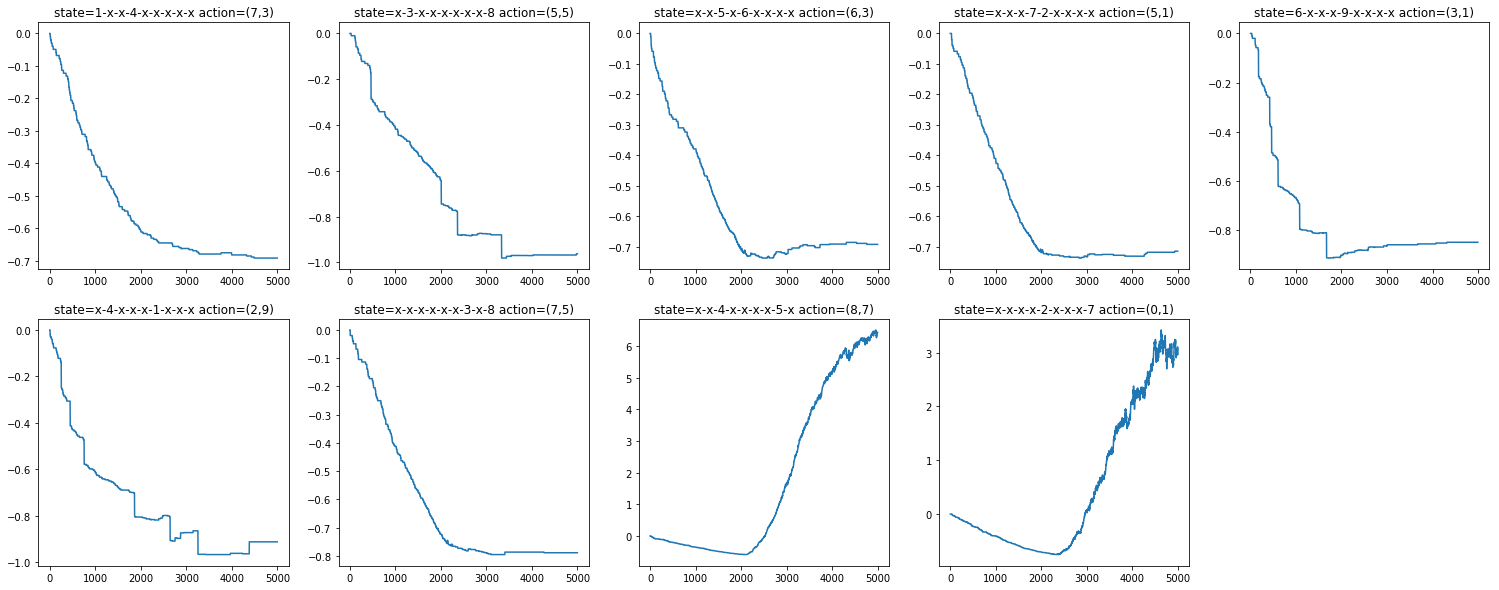

In [21]:
#print(type(xaxis))

plt.figure(0, figsize=(26,10))
plt.subplot(251)
plt.title('state=''1-x-x-4-x-x-x-x-x'' action=(7,3)')
xaxis = np.asarray(range(0, len(States_track['1-x-x-4-x-x-x-x-x'][(7,3)])))
plt.plot(xaxis,np.asarray(States_track['1-x-x-4-x-x-x-x-x'][(7,3)]))
plt.subplot(252)
plt.title('state=''x-3-x-x-x-x-x-x-8'' action=(5,5)')
xaxis = np.asarray(range(0, len(States_track['x-3-x-x-x-x-x-x-8'][(5,5)])))
plt.plot(xaxis,np.asarray(States_track['x-3-x-x-x-x-x-x-8'][(5,5)]))
plt.subplot(253)
plt.title('state=''x-x-5-x-6-x-x-x-x'' action=(6,3)')
xaxis = np.asarray(range(0, len(States_track['x-x-5-x-6-x-x-x-x'][(6,3)])))
plt.plot(xaxis,np.asarray(States_track['x-x-5-x-6-x-x-x-x'][(6,3)]))
plt.subplot(254)
plt.title('state=''x-x-x-7-2-x-x-x-x'' action=(5,1)')
xaxis = np.asarray(range(0, len(States_track['x-x-x-7-2-x-x-x-x'][(5,1)])))
plt.plot(xaxis,np.asarray(States_track['x-x-x-7-2-x-x-x-x'][(5,1)]))
plt.subplot(255)
plt.title('state=''6-x-x-x-9-x-x-x-x'' action=(3,1)')
xaxis = np.asarray(range(0, len(States_track['6-x-x-x-9-x-x-x-x'][(3,1)])))
plt.plot(xaxis,np.asarray(States_track['6-x-x-x-9-x-x-x-x'][(3,1)]))
plt.subplot(256)
plt.title('state=''x-4-x-x-x-1-x-x-x'' action=(2,9)')
xaxis = np.asarray(range(0, len(States_track['x-4-x-x-x-1-x-x-x'][(2,9)])))
plt.plot(xaxis,np.asarray(States_track['x-4-x-x-x-1-x-x-x'][(2,9)]))
plt.subplot(257)
plt.title('state=''x-x-x-x-x-x-3-x-8'' action=(7,5)')
xaxis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-3-x-8'][(7,5)])))
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-3-x-8'][(7,5)]))
plt.subplot(258)
plt.title('state=''x-x-4-x-x-x-x-5-x'' action=(8,7)')
xaxis = np.asarray(range(0, len(States_track['x-x-4-x-x-x-x-5-x'][(8,7)])))
plt.plot(xaxis,np.asarray(States_track['x-x-4-x-x-x-x-5-x'][(8,7)]))
plt.subplot(259)
plt.title('state=''x-x-x-x-2-x-x-x-7'' action=(0,1)')
xaxis = np.asarray(range(0, len(States_track['x-x-x-x-2-x-x-x-7'][(0,1)])))
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-2-x-x-x-7'][(0,1)]))
plt.show()

### Epsilon - decay check

In [25]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

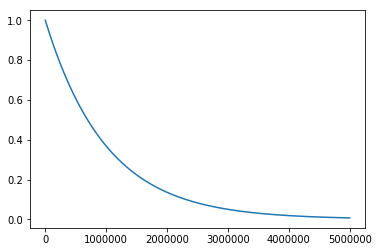

In [26]:
plt.plot(time, epsilon)
plt.show()